# Showcase of Initial Conditions in 1d

Initial conditions affect the dynamics produced by the timesteppers.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import exponax as ex

### Introduction

In the simplest case, we can define an initial condition by creating a grid and
discretizing a function on it. For example, the first sine mode.

2024-04-09 15:29:54.285141: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


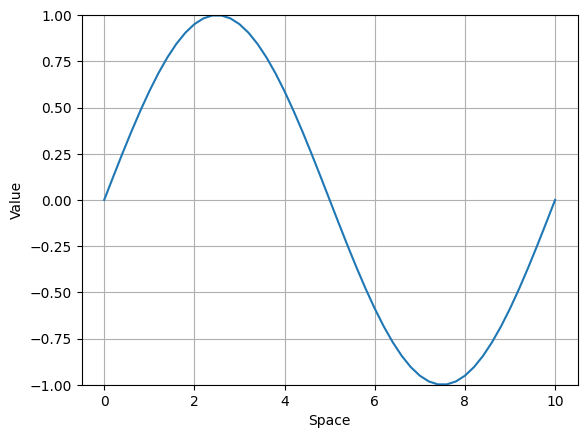

In [3]:
DOMAIN_EXTENT = 10.0
NUM_POINTS = 50

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)

u_0 = jnp.sin(2 * jnp.pi / DOMAIN_EXTENT * grid)

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

This can be randomized by changing the amplitude and phase of the sine mode.
Here, we will draw these values from a uniform distribution:

$$
a \propto \mathcal{U}(-1, 1)
$$

$$
\phi \propto \mathcal{U}(0, 2\pi)
$$

then the initial condition is

$$
u(x) = a \sin(2\pi/L x + \phi)
$$

Amplitude: 0.114
Phase: 0.662


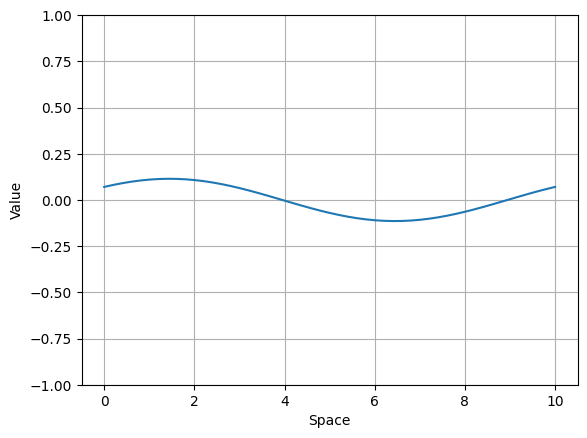

In [4]:
main_key = jax.random.PRNGKey(0)

amplitude_key, phase_key = jax.random.split(main_key)

amplitude = jax.random.uniform(amplitude_key, (), minval=-1.0, maxval=1.0)
phase = jax.random.uniform(phase_key, (), minval=0.0, maxval=2 * jnp.pi)

print(f"Amplitude: {amplitude:.3f}")
print(f"Phase: {phase:.3f}")

ic_fun = lambda x: amplitude * jnp.sin(2 * jnp.pi / DOMAIN_EXTENT * x + phase)

u_0 = ic_fun(grid)

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

Let's also create an initial condition that consists of two sine modes, the
first and the second. We will again draw the amplitudes and phases from the same
uniform distribution.

Amplitudes: [-0.03947949 -0.52326775]
Phases: [3.622575  1.8797542]


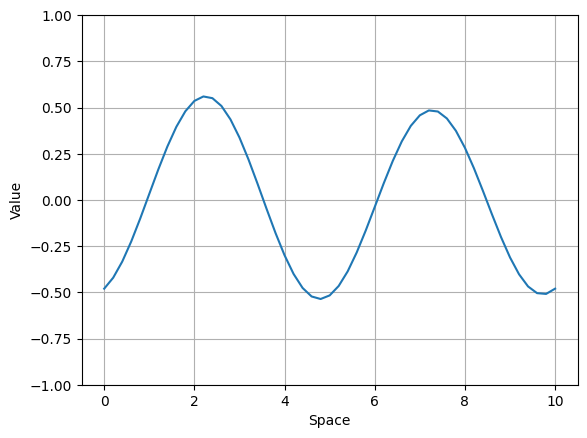

In [5]:
amplitude_s = jax.random.uniform(amplitude_key, (2,), minval=-1.0, maxval=1.0)
phase_s = jax.random.uniform(phase_key, (2,), minval=0.0, maxval=2 * jnp.pi)

print(f"Amplitudes: {amplitude_s}")
print(f"Phases: {phase_s}")

ic_fun = lambda x: amplitude_s[0] * jnp.sin(
    2 * jnp.pi / DOMAIN_EXTENT * x + phase_s[0]
) + amplitude_s[1] * jnp.sin(4 * jnp.pi / DOMAIN_EXTENT * x + phase_s[1])

u_0 = ic_fun(grid)

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

Notice that in both cases we first created a lambda function that represented
the "continuous" version of the initial condition function which we subsequently
discretized on the grid.

In `Exponax` there is a representation for such a sine function that is (like
the time steppers or any other `equinox.Module` simply a callable PyTree).

In [6]:
sine_waves = ex.ic.SineWaves1d(
    DOMAIN_EXTENT, amplitude_s, jnp.arange(1, 2 + 1), phase_s
)

sine_waves

SineWaves1d(
  domain_extent=10.0,
  amplitudes=f32[2],
  wavenumbers=i32[2],
  phases=f32[2],
  offset=0.0,
  std_one=False,
  max_one=False
)

We can also evaluate it on the grid

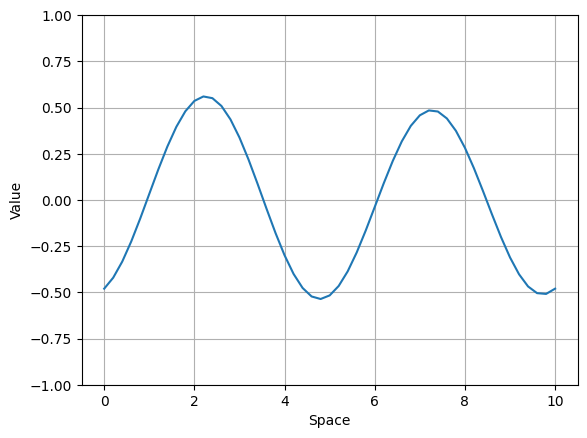

In [7]:
u_0 = sine_waves(grid)

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

`Exponax` offers a way to randomly generate initial conditions of this sine
type. For this, we first instantiate a `RandomSineWaves1d` generator. You can
think of it as a "distribution over initial conditions" of the aforementioned
type.

In [8]:
sine_ic_gen = ex.ic.RandomSineWaves1d(
    1,  # num_spatial_dims fixed to 1
    domain_extent=DOMAIN_EXTENT,
    cutoff=2,  # how many modes are included
)

This generator can now be queried to produce another sine wave initial condition
(as a "continuous function")

In [9]:
new_sine_waves_ic = sine_ic_gen.gen_ic_fun(key=jax.random.PRNGKey(1))

new_sine_waves_ic

SineWaves1d(
  domain_extent=10.0,
  amplitudes=f32[2],
  wavenumbers=i32[2],
  phases=f32[2],
  offset=f32[],
  std_one=False,
  max_one=False
)

Let us evaluate it on the grid

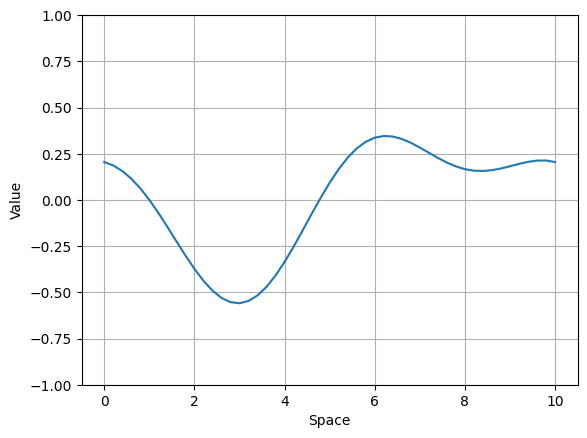

In [10]:
u_0 = new_sine_waves_ic(grid)

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

Oftentimes, when creating initial conditions for the dynamics in `Exponax`, we
are not interested in its continuous representation, but rather in its
discretized version. For this, we can directly call the generator with the
number of points as an argument. Internally, it will generate a function and a
grid and return the discretized function.

Both ways should result in the same initial state (given the same random key).

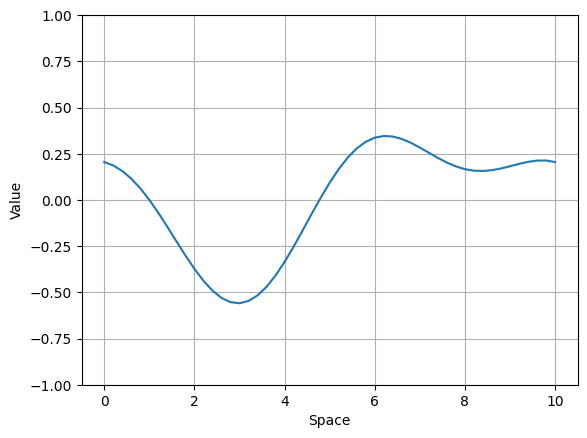

In [11]:
u_0 = sine_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

For many applications, we are interested in rolling out dynamics for multiple
initial conditions. For this, we can batch execute the generator on a range of
keys.

(5, 1, 50)


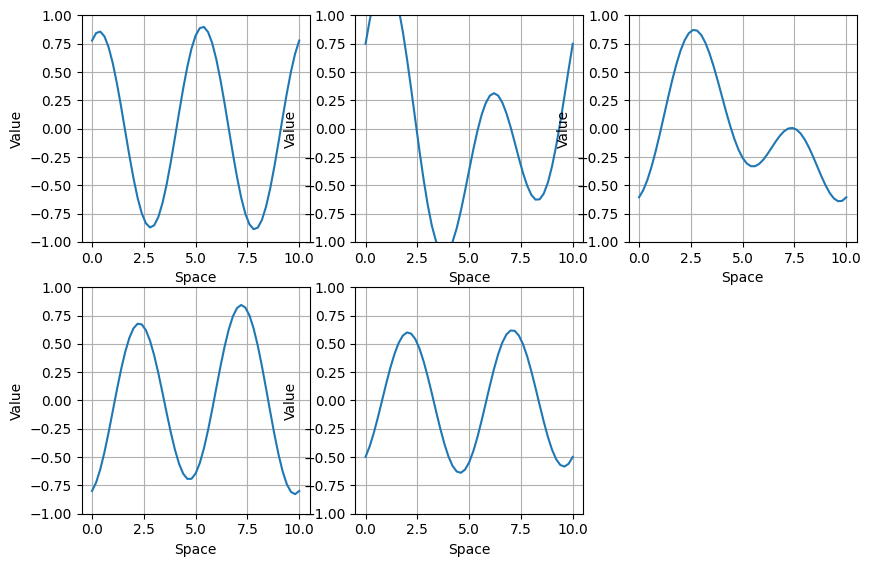

In [12]:
main_key = jax.random.PRNGKey(42)

five_keys = jax.random.split(main_key, 5)

five_u_0 = jnp.stack([sine_ic_gen(NUM_POINTS, key=key) for key in five_keys])

print(five_u_0.shape)

ex.viz.plot_state_1d_facet(five_u_0, domain_extent=DOMAIN_EXTENT);

Since the task of evaluating a generator for multiple initial conditions is an
common task, there is special function in `Exponax` that does this for us.

In [13]:
more_u_0 = ex.build_ic_set(
    sine_ic_gen,
    num_points=NUM_POINTS,
    num_samples=5,
    key=jax.random.PRNGKey(73),
)

print(more_u_0.shape)

ex.viz.plot_state_1d_facet(more_u_0, domain_extent=DOMAIN_EXTENT);

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function scan_fn at /home/koehler/Repos/exponax/exponax/_utils.py:329 for scan. This concrete value was not available in Python because it depends on the value of the argument k.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

### Gaussian Blobs

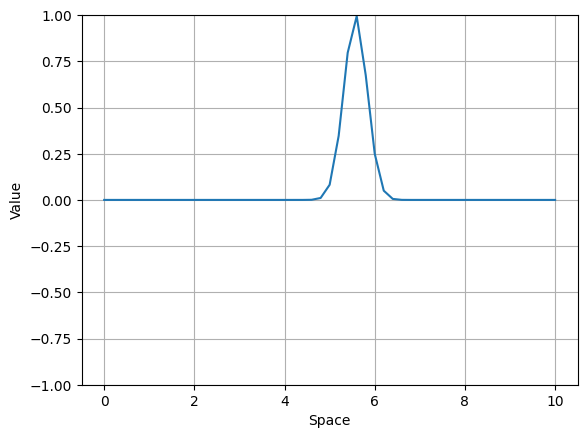

In [14]:
gaussian_blob_ic_gen = ex.ic.RandomGaussianBlobs(
    1,
    domain_extent=DOMAIN_EXTENT,
    num_blobs=1,
)

u_0 = gaussian_blob_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

### Discontinuities

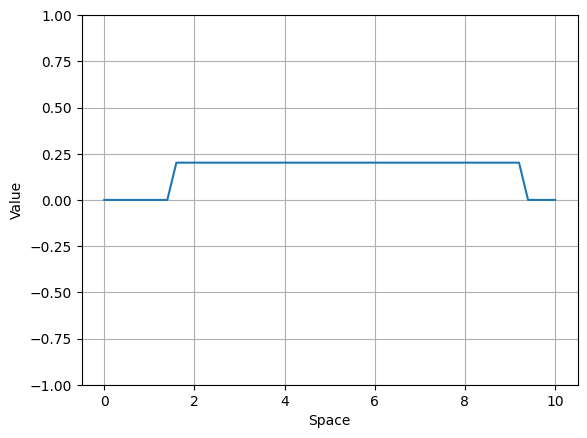

In [15]:
discontinuity_ic_gen = ex.ic.RandomDiscontinuities(
    1,
    domain_extent=DOMAIN_EXTENT,
    num_discontinuities=1,
)

u_0 = discontinuity_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

### Gaussian Random Field

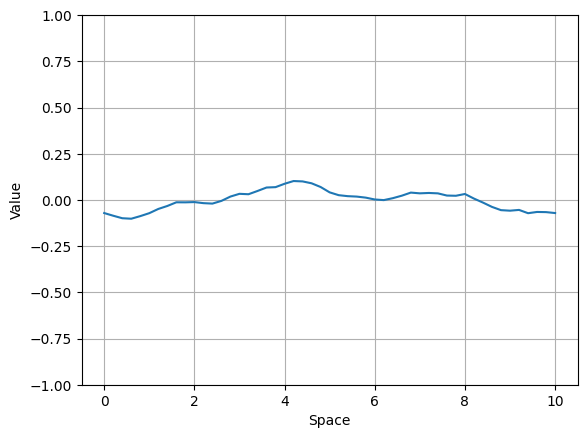

In [16]:
grf_ic_gen = ex.ic.GaussianRandomField(
    1,
)

u_0 = grf_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

### Diffused Noise

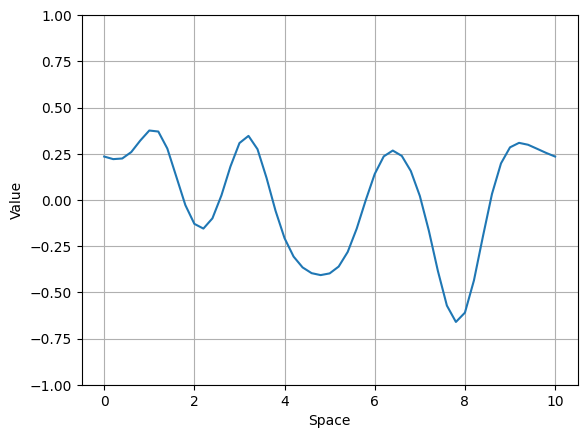

In [17]:
diffused_noise_ic_gen = ex.ic.DiffusedNoise(
    1,
)

u_0 = diffused_noise_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

### Truncated Fourier Series

Conceptually very similar to the sine waves, but also correctly operates in
higher dimensions. However, we cannot explicitly draw a continuous function. The
produced state is also different for different resolutions (`num_points`).

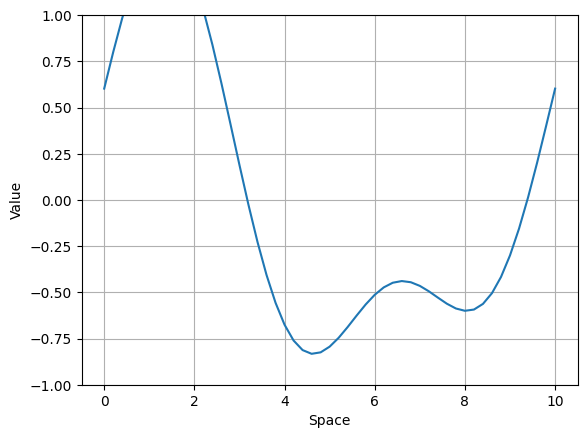

In [18]:
truncated_fourier_ic_gen = ex.ic.RandomTruncatedFourierSeries(
    1,
    cutoff=2,
)

u_0 = truncated_fourier_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

## Meta Generators

### Multi-Channel IC Generator

For example relevant for dynamics with multiple species. (In higher dimensions
also relevant for convection problems like Burgers equation)

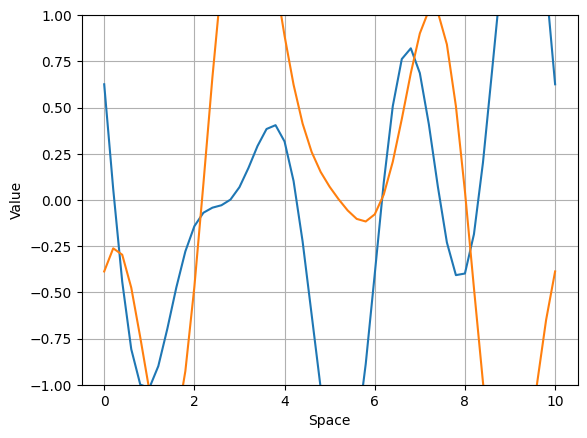

In [19]:
truncated_fourier_ic_gen = ex.ic.RandomTruncatedFourierSeries(
    1,
    cutoff=4,
)

multi_channel_ic_gen = ex.ic.RandomMultiChannelICGenerator(
    [
        truncated_fourier_ic_gen,
        truncated_fourier_ic_gen,  # Can also use two different generators
    ]
)

u_0 = multi_channel_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

### Clamping IC Generator

Clamps the initial condition to a certain range. For example, this is useful for
some dynamics that expect initial conditions to be within $[0, 1]$ (like the
Fisher-KPP equation).

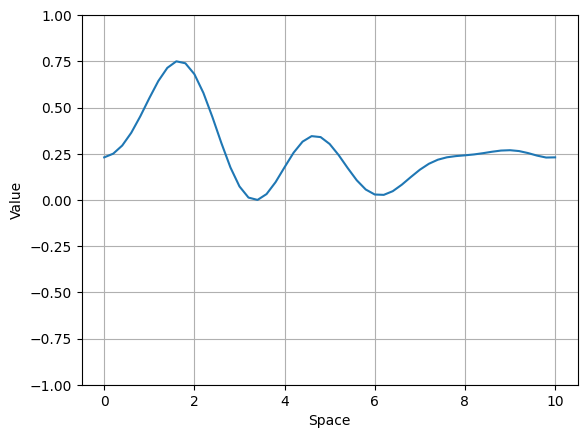

In [20]:
truncated_fourier_ic_gen = ex.ic.RandomTruncatedFourierSeries(
    1,
    cutoff=4,
)

clamped_truncated_fourier_ic_gen = ex.ic.ClampingICGenerator(
    truncated_fourier_ic_gen,
    limits=(0.0, 0.75),
)

u_0 = clamped_truncated_fourier_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

### Scaled IC Generator

Scales the initial condition by a fixed value.

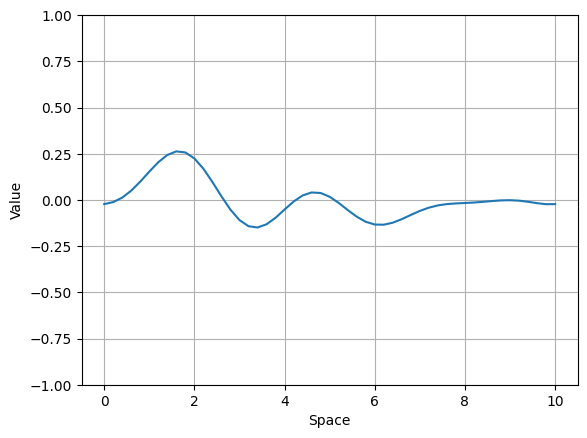

In [22]:
truncated_fourier_ic_gen = ex.ic.RandomTruncatedFourierSeries(
    1,
    cutoff=4,
)

scaled_truncated_fourier_ic_gen = ex.ic.ScaledICGenerator(
    truncated_fourier_ic_gen,
    scale=0.1,
)

u_0 = scaled_truncated_fourier_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

## Modifications

Almost all IC generators support the following modifications:

- `zero_mean`: Shifts the mean of the initial condition to zero.
- `std_one`: Scales the standard deviation of the initial condition to one.
    (this only works with `zero_mean = True` enabled)
- `max_one`: Scales the maximum absolute of the initial condition to one.

Especially the last is helpful to limit the order of magnitude of the initial
condition. This is important for many dynamics, as they are sensitive to it
(e.g., Burgers equation).

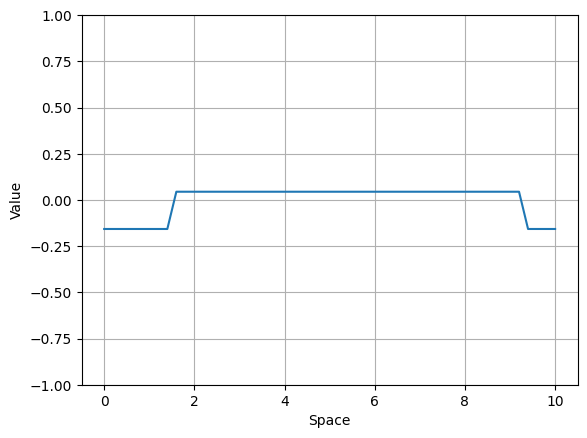

In [33]:
grf_ic_gen = ex.ic.RandomDiscontinuities(
    1,
    num_discontinuities=1,
    zero_mean=True,
)

u_0 = grf_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

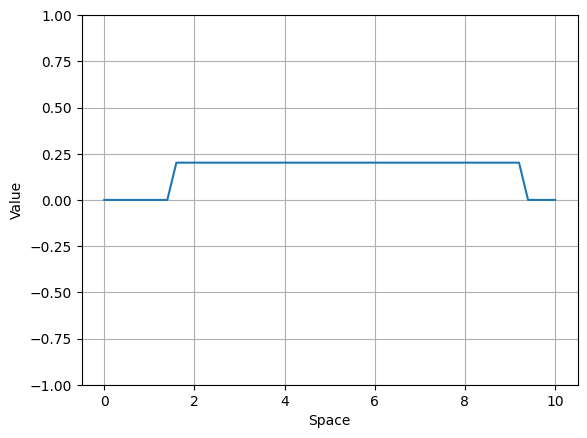

In [34]:
grf_ic_gen_nonzero = ex.ic.RandomDiscontinuities(
    1,
    num_discontinuities=1,
    zero_mean=False,
)

u_0 = grf_ic_gen_nonzero(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

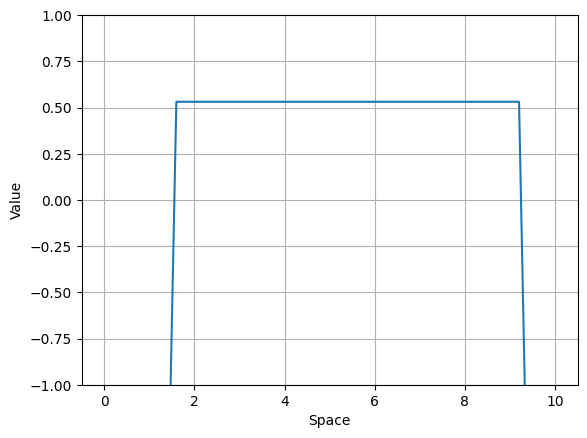

In [36]:
grf_std_one = ex.ic.RandomDiscontinuities(
    1,
    num_discontinuities=1,
    zero_mean=True,
    std_one=True,
)

u_0 = grf_std_one(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);

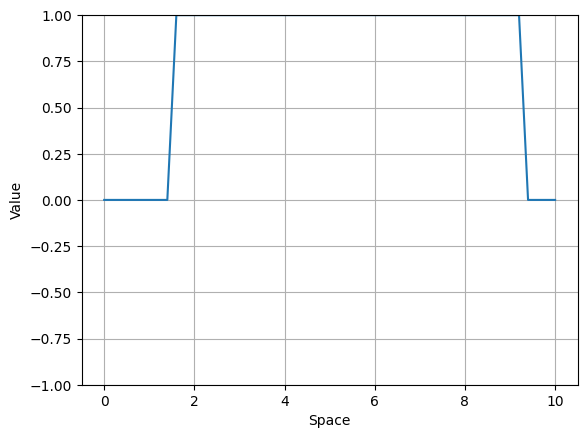

In [37]:
grf_max_one = ex.ic.RandomDiscontinuities(
    1,
    num_discontinuities=1,
    max_one=True,
)

u_0 = grf_max_one(NUM_POINTS, key=jax.random.PRNGKey(1))

ex.viz.plot_state_1d(u_0, domain_extent=DOMAIN_EXTENT);